In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set_theme()

# Reading and simulating the necessary data

## Weather data

Because of an obvious lack of data accessibility, for the moment data should either be found from open data, or simulated. Information (and data) lacks especially in the case of hydrogen consumption. But it is still possible to simulate it using a Poisson distribution.

Before reaching the case of hydrogen demand, some important weather forecasts and measures are accessible. In the example the purpose is to model an on-site hydrogen production and refueling station, a renewable energy production is an essential part of the power sources. Generally green energy producers are either wind turbines or solar panels. For the moment and because data has been found a wind turbine will be considered in the example.
Wind turbines production capacity depends on the wind speed and the technical capacities of the turbine (cut-in/cut-out speed, rated power...). Luckily there is a website *meteonet* which contains data made available by METEO FRANCE with weather forecasts and wind speed information from ground stations in the North West of France.

There are a lot of ground stations available, but for the sake of example only one station is kept (the first that appears...). Data was available for three years 2016, 2017, and 2018. All these years were kept in order enough data to feed the algorithms.

In [3]:
file_list = ['NW2016.csv', 'NW2017.csv', 'NW2018.csv']
PATH = "../data/NW_ground_stations/"
df_list = []
for file in file_list:
    df = pd.read_csv(PATH + file)
    df = df.query("number_sta == 14066001")
    df.date = pd.to_datetime(df.date)
    df.set_index('date', inplace=True)
    # In order to fill NaN values for the wind speed variable, 'ff' a forward fill will be enough
    df_list.append(df)

Concatenating all the dataframes for 2016, 2017 and 2018. With a datetime index with a 6 minute interval. Source: https://meteonet.umr-cnrm.fr/

In [4]:
weather = pd.concat(df_list)

Because the granularity is low and there are only a few missing data for the *ff* variable, adding to the fact that wind speed rarely vary greatly in 6 minutes. It has been decided to use a forward fill to fill the missing values.
It means the missing values will be replaced by the wind of the previous row.

In [5]:
# weather.ff = weather.ff.ffill()

In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262780 entries, 2016-01-01 00:00:00 to 2018-12-31 23:54:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   number_sta  262780 non-null  int64  
 1   lat         262780 non-null  float64
 2   lon         262780 non-null  float64
 3   height_sta  262780 non-null  float64
 4   dd          262761 non-null  float64
 5   ff          262761 non-null  float64
 6   precip      262780 non-null  float64
 7   hu          260939 non-null  float64
 8   td          260390 non-null  float64
 9   t           262213 non-null  float64
 10  psl         0 non-null       float64
dtypes: float64(10), int64(1)
memory usage: 24.1 MB


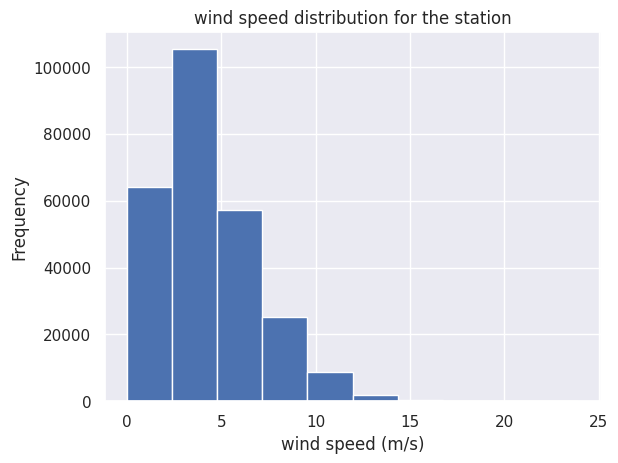

In [7]:
weather.ff.plot(kind='hist')
plt.title('wind speed distribution for the station')
plt.xlabel('wind speed (m/s)');
plt.savefig("./plots/ws_distribution.png")

**Comments on wind speed histogram:**
Wind speed is given meter per second (m/s). Naturally the smallest value is zero and the histogram shows that the average wind speed is around five m/s. The curve is skewed towards zero because high wind speed are a rather rare occurrence, which happens to be a good thing, because when there is too much wind, wind turbines stop working.

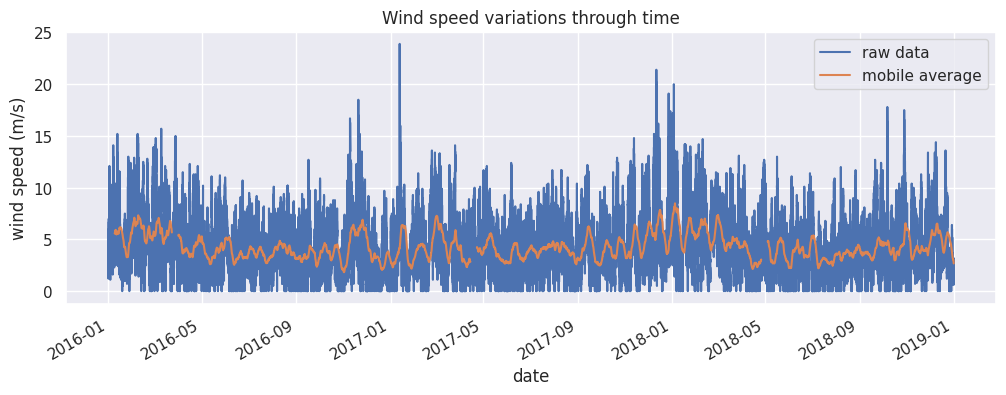

In [10]:
plt.figure(figsize=(12, 4))
weather.ff.plot(label='raw data')
weather.ff.rolling(window=2000).mean().plot(label='mobile average')
plt.ylabel('wind speed (m/s)')
plt.title('Wind speed variations through time')
plt.legend();
#plt.savefig("./plots/ws_var.png")

**Comments about the plot above:**
The plot above shows the wind speed variations through time. There are two curves, the blule curve shows the raw data as recorded by the station. The orange curve represents the smoothed time series with a mobile average and window of 2000 units of time (because measures are made every 6 minutes). The purpose of the smoothing was to show eventual seasonalities. There doesn't seem to be a trend in wind speed through time and the high variations are of course to volatile aspect of weather (especially wind). But it is still possible to perceive some seasonalities when observing the curves. It appears that there is an increase in wind speed around the month of january (during winter) with obvious peaks in january of 2017 and 2018 (blue curve).

N.B. It is worth mentionning that there the moving average contains some holes. It is certainly due to the presence of missing data during this time period. These holes also seem to appear around the same time of year (between march and april) for all years.

In [11]:
wind_speed = weather[['ff']]

In [12]:
wind_speed.shape

(262780, 1)

In [13]:
wind_speed.loc["2016-05-15 03:50:00":].head(20)

,ff
date,
2016-05-15 03:54:00,2.8
2016-05-15 08:06:00,2.9
2016-05-15 08:12:00,2.9
2016-05-15 08:18:00,3.1
2016-05-15 08:24:00,3.2
2016-05-15 08:30:00,3.4
2016-05-15 08:36:00,3.2
2016-05-15 08:42:00,3.0
2016-05-15 08:48:00,3.2


## Dealing with missing data

As appears in the plot above, there are some missing data. Further investigation should me made as to the size and how it can be dealt with.

In [14]:
wind_speed.isna().sum()

ff    19
dtype: int64

In [15]:
wind_speed[wind_speed.ff.isna()]

,ff
date,
2016-03-23 10:24:00,NaN
2016-03-23 10:30:00,NaN
2016-03-23 10:36:00,NaN
2016-03-23 10:42:00,NaN
2017-04-14 09:24:00,NaN
2017-04-14 09:30:00,NaN
2017-04-14 09:36:00,NaN
2017-04-14 09:42:00,NaN
2017-04-14 09:48:00,NaN


It seems that there are nineteen rows with a missing value on the wind speed. Since missing data concerns just some points on march 23rd 2016, april 14th 2017 and April 26th of 2018. It is possible to fill these missing values with a simple strategy in this case, a forward fill. The forward fill allows to replace the missing value with the previously available value. In this case, it can be relevant if it is admitted that wind speed despite its volatility the small granularity of the data makes a forward fill possible (wind speed shouldn't change this fast).

In [16]:
wind_speed.ff.fillna(method='ffill', inplace=True)

/tmp/ipykernel_12093/921890852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_speed.ff.fillna(method='ffill', inplace=True)


In [17]:
wind_speed.isna().sum()

ff    0
dtype: int64

## Viz of wind speed distribution per month

In [18]:
from copy import deepcopy
wind_speed_2 = deepcopy(wind_speed)

In [19]:
wind_speed_2['month'] = wind_speed_2.index.month

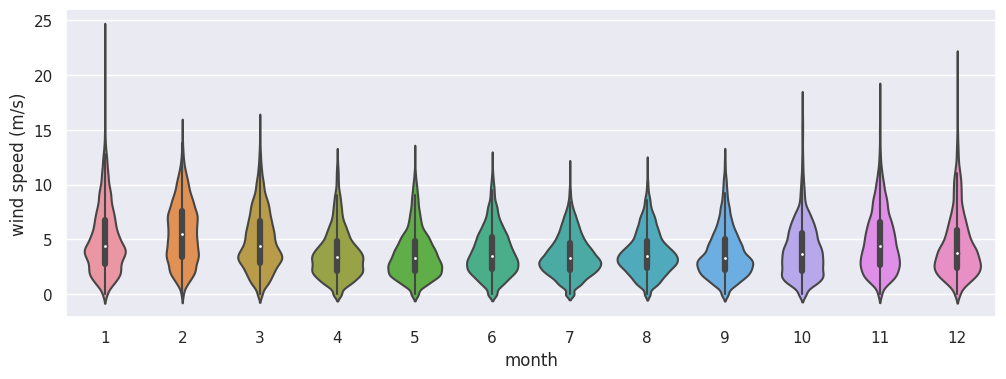

In [21]:
plt.figure(figsize=(12, 4))

sns.violinplot(x='month', y='ff', data=wind_speed_2)
plt.ylabel('wind speed (m/s)');
plt.savefig("./plots/ws_violinplots_month.png")

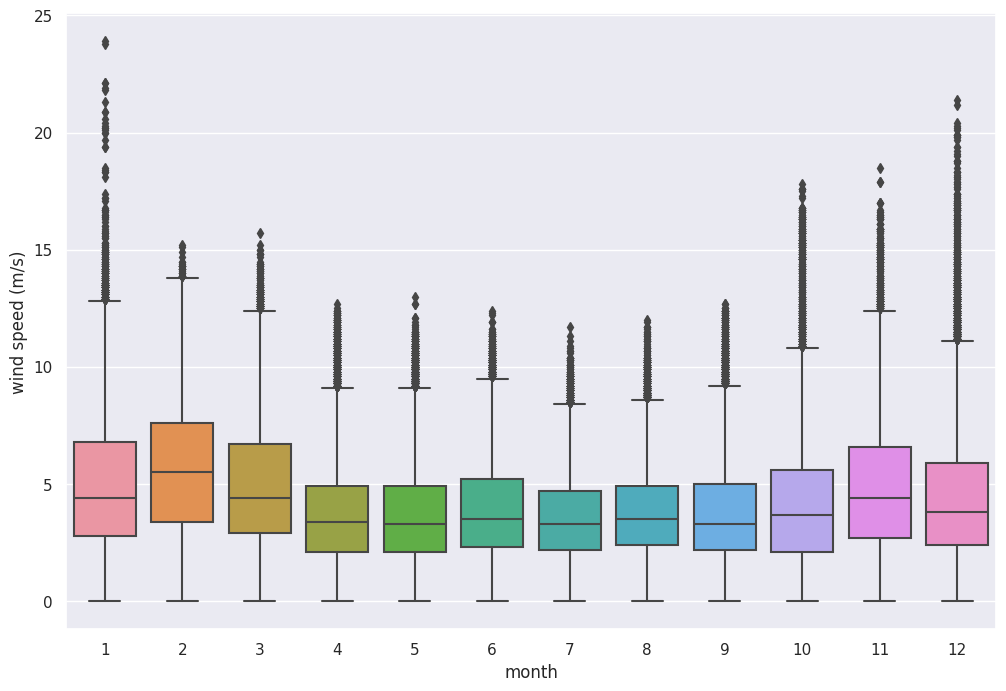

In [23]:
plt.figure(figsize=(12, 8))
sns.set_theme()
sns.boxplot(x='month', y='ff', data=wind_speed_2)
plt.ylabel('wind speed (m/s)');
plt.savefig("./plots/ws_boxplots_month.png")

In [20]:
# wind_speed.to_csv('../data/wind_speed.csv')

In [26]:
# creating a 15 minutes resampled data
wsh15 = wind_speed.resample('15min').mean()

In [29]:
wsh = wind_speed.resample('H').mean()

In [30]:
wsh.shape

(26304, 1)

# Simulating a corresponding Poisson distribution for FCEV demand

The lack of data when it comes to hydrogen demand is mainly due to the the fact that the industry is still recent and lacks consistent data. In order to answer this problem, it is important to get an approximation as to the needs for hydrogen stations, this is why simulations are the necessary approach used for getting approximate values as to the needs of the industry. In litterature, HV's demand is always represented with Poisson process because it is a non-negative integer valued function. The other important assumption for the Poisson process, is that the occurence of two events are independant. This means that the arrival of a vehicle doesn't depend on the arrival of the previous one.
For the moment it will be considered that there is approximately 3 vehicles arriving every hour. Adding to that it will just be assumed that the average amount of hydrogen needed for each vehicle is 3.13 kg of hydrogen (cite the paper where the information is contained).

- So for the moment the amount of hydrogen needed will just be the product between the number of arrival and the average amount needed, consdering that the average of 3.13 represents the expected amount needed for the refuel.

There are other methods that can be used in order to get a more *thourough* simulation, but there is no need to get this far for the moment. The objective here is to obtain data in order to get a functional environment for the reinforcement learning approach.

In [31]:
fcev_demand_15min = np.random.poisson(1, wsh15.shape[0])

In [38]:
fcev_demand_15min = pd.DataFrame(fcev_demand_15min, index=wsh15.index, columns=['fcev_demand'])

In [33]:
fcev_demand_hourly = np.random.poisson(3, wsh.shape[0])

In [39]:
fcev_demand_hourly = pd.DataFrame(fcev_demand_hourly, index=wsh.index, columns=['fcev_demand'])

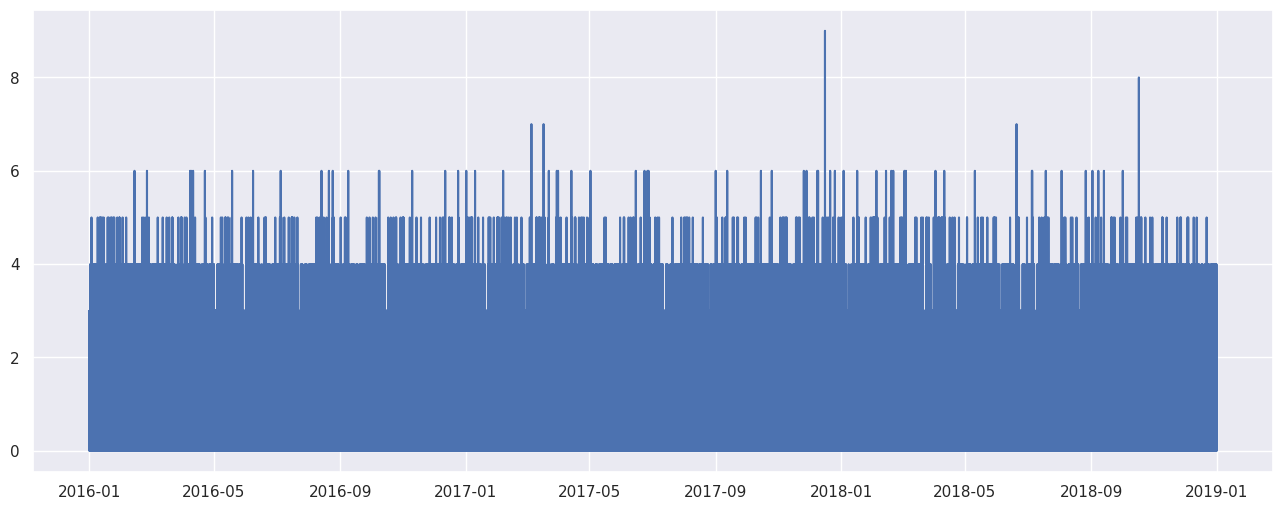

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(wsh15.index, fcev_demand_15min.fcev_demand)

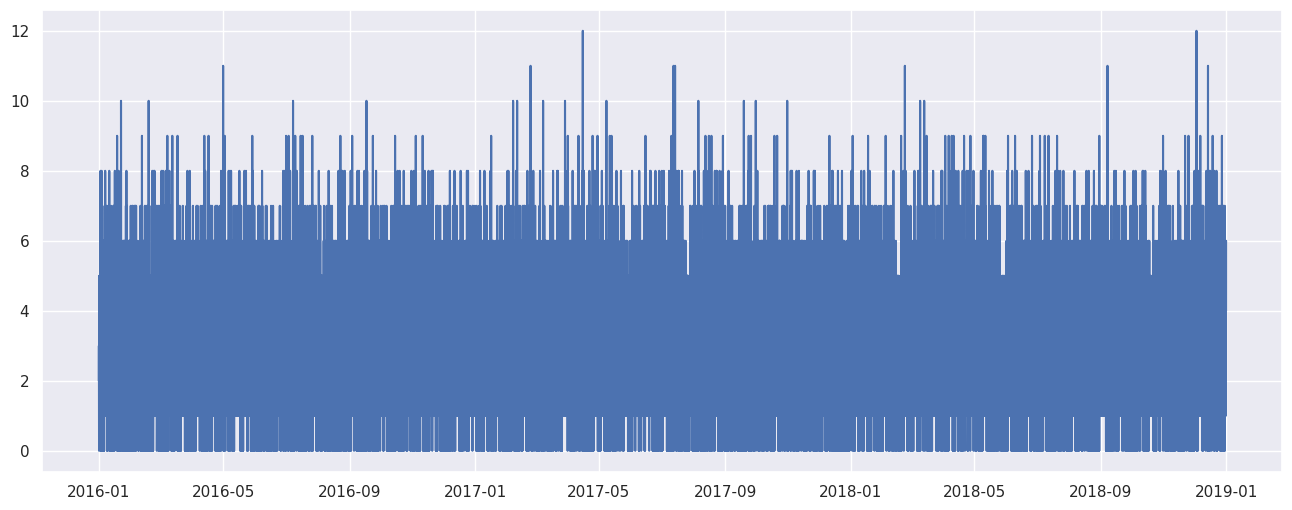

In [42]:
plt.figure(figsize=(16, 6))
plt.plot(wsh.index, fcev_demand_hourly.fcev_demand)

In [43]:
fcev_demand_hourly.query('fcev_demand==0').shape

(1333, 1)

In [45]:
fcev_demand_15min.query('fcev_demand==0').shape

(38791, 1)

In [46]:
fcev_demand_hourly.describe()

,fcev_demand
count,26304.000000
mean,2.969168
std,1.722465
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


In [47]:
fcev_demand_15min.describe()

,fcev_demand
count,105216.000000
mean,1.000409
std,1.001975
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,9.000000


In [48]:
fcev_demand_15min['h2_amount'] = fcev_demand_15min.fcev_demand * 3.13

In [49]:
fcev_demand_hourly['h2_amount'] = fcev_demand_hourly.fcev_demand * 3.13

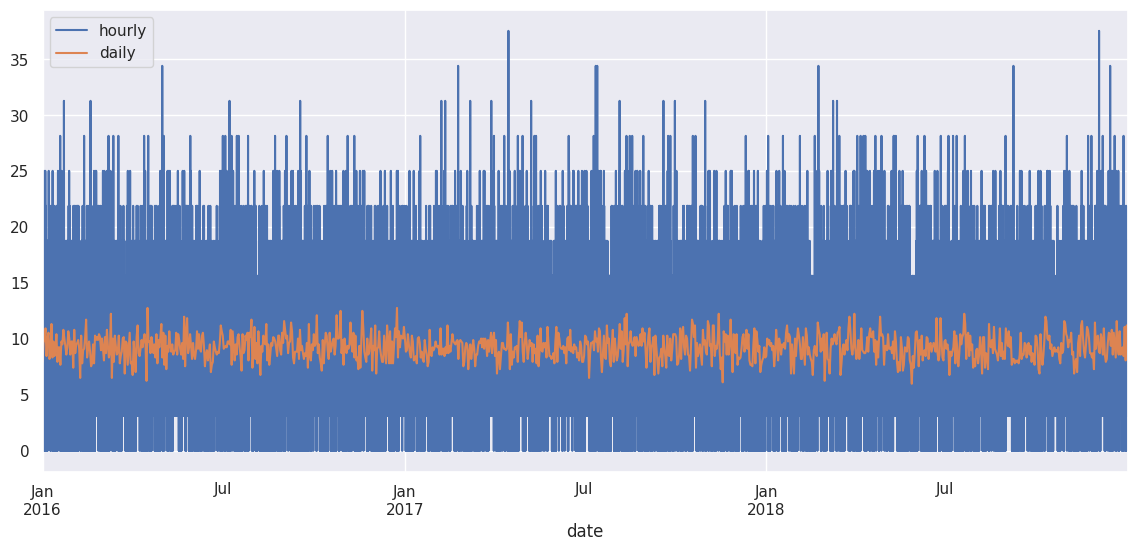

In [50]:
plt.figure(figsize=(14, 6))
fcev_demand_hourly['h2_amount'].plot(label="hourly")
fcev_demand_hourly['h2_amount'].resample('D').mean().plot(label="daily")
plt.legend()

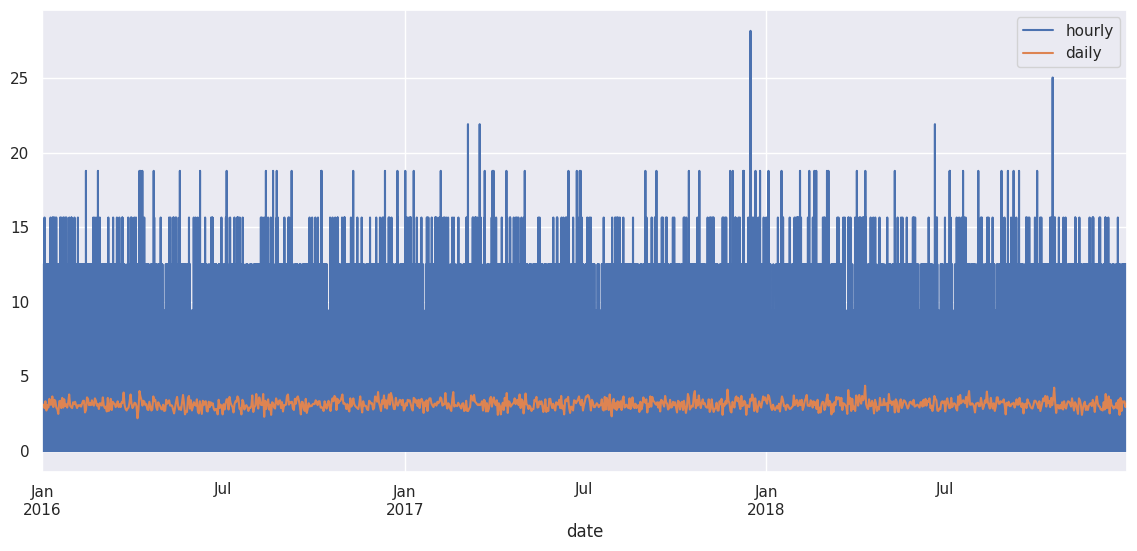

In [51]:
plt.figure(figsize=(14, 6))
fcev_demand_15min['h2_amount'].plot(label="hourly")
fcev_demand_15min['h2_amount'].resample('D').mean().plot(label="daily")
plt.legend()

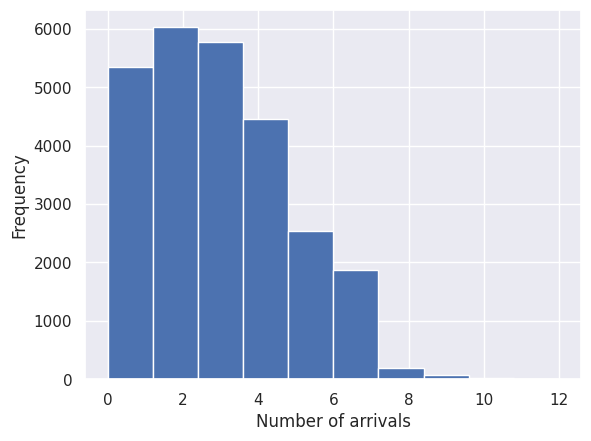

In [52]:
fcev_demand_hourly['fcev_demand'].plot(kind='hist')
plt.xlabel('Number of arrivals');
# plt.savefig('./plots/fcev_demand_poisson.png')

<AxesSubplot:ylabel='Frequency'>

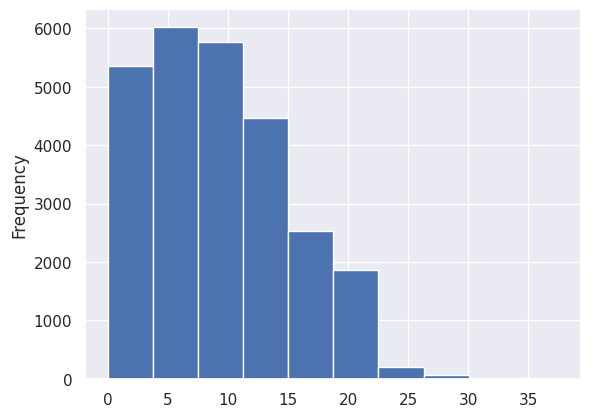

In [53]:
fcev_demand_hourly['h2_amount'].plot(kind='hist')

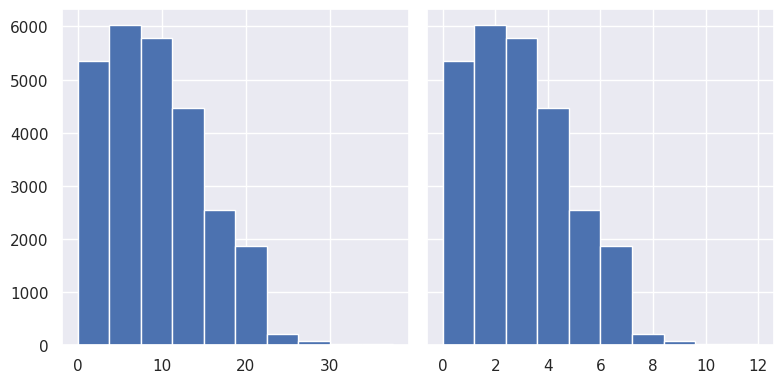

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
ax[0].hist(fcev_demand_hourly['h2_amount'])
ax[1].hist(fcev_demand_hourly['fcev_demand']) 
fig.tight_layout()

In [55]:
print(wind_speed.resample('H').mean().shape)
print(fcev_demand_hourly.shape)

(26304, 1)
(26304, 2)


In [56]:
wind_speed.shape

(262780, 1)

In [57]:
wind_speed.loc["2016-05-15 03:50:00":].head(20)

,ff
date,
2016-05-15 03:54:00,2.8
2016-05-15 08:06:00,2.9
2016-05-15 08:12:00,2.9
2016-05-15 08:18:00,3.1
2016-05-15 08:24:00,3.2
2016-05-15 08:30:00,3.4
2016-05-15 08:36:00,3.2
2016-05-15 08:42:00,3.0
2016-05-15 08:48:00,3.2


In [58]:
wsh[wsh['ff'].isna()]

,ff
date,
2016-05-15 04:00:00,NaN
2016-05-15 05:00:00,NaN
2016-05-15 06:00:00,NaN
2016-05-15 07:00:00,NaN
2016-05-19 09:00:00,NaN
2016-05-19 10:00:00,NaN
2016-05-19 11:00:00,NaN
2016-05-19 12:00:00,NaN
2016-05-24 06:00:00,NaN


In [59]:
wsh15[wsh15['ff'].isna()]

,ff
date,
2016-03-17 09:15:00,NaN
2016-03-17 09:30:00,NaN
2016-03-17 09:45:00,NaN
2016-05-15 04:00:00,NaN
2016-05-15 04:15:00,NaN
...,...
2018-08-21 10:45:00,NaN
2018-08-21 11:00:00,NaN
2018-08-21 11:15:00,NaN


In [67]:
wind_data = wsh.join(fcev_demand_hourly, how='left')

In [68]:
wind_data.shape

(26304, 3)

In [69]:
wind_data_15 = wsh15.join(fcev_demand_15min, how='left')

In [70]:
wind_data.rename(columns={'ff':'wind_speed'}, inplace=True)
wind_data_15.rename(columns={'ff':'wind_speed'}, inplace=True)

In [71]:
wind_data.head()

,wind_speed,fcev_demand,h2_amount
date,,,
2016-01-01 00:00:00,3.05,2,6.26
2016-01-01 01:00:00,2.57,3,9.39
2016-01-01 02:00:00,2.26,3,9.39
2016-01-01 03:00:00,2.62,2,6.26
2016-01-01 04:00:00,2.99,2,6.26


In [72]:
wind_data_15.head()

,wind_speed,fcev_demand,h2_amount
date,,,
2016-01-01 00:00:00,4.033333,3,9.39
2016-01-01 00:15:00,3.100000,0,0.00
2016-01-01 00:30:00,2.600000,0,0.00
2016-01-01 00:45:00,2.200000,1,3.13
2016-01-01 01:00:00,2.666667,1,3.13


In [74]:
wind_data.query("fcev_demand == 0")

,wind_speed,fcev_demand,h2_amount
date,,,
2016-01-01 06:00:00,2.32,0,0.0
2016-01-02 19:00:00,8.06,0,0.0
2016-01-03 11:00:00,7.83,0,0.0
2016-01-04 12:00:00,9.04,0,0.0
2016-01-05 12:00:00,7.63,0,0.0
...,...,...,...
2018-12-27 20:00:00,3.50,0,0.0
2018-12-29 11:00:00,4.04,0,0.0
2018-12-29 12:00:00,3.62,0,0.0


In [75]:
wind_data[wind_data['wind_speed'].isna()]

,wind_speed,fcev_demand,h2_amount
date,,,
2016-05-15 04:00:00,NaN,2,6.26
2016-05-15 05:00:00,NaN,4,12.52
2016-05-15 06:00:00,NaN,5,15.65
2016-05-15 07:00:00,NaN,3,9.39
2016-05-19 09:00:00,NaN,4,12.52
2016-05-19 10:00:00,NaN,2,6.26
2016-05-19 11:00:00,NaN,3,9.39
2016-05-19 12:00:00,NaN,0,0.00
2016-05-24 06:00:00,NaN,0,0.00


In [76]:
wind_data_15[wind_data_15['wind_speed'].isna()]

,wind_speed,fcev_demand,h2_amount
date,,,
2016-03-17 09:15:00,NaN,2,6.26
2016-03-17 09:30:00,NaN,0,0.00
2016-03-17 09:45:00,NaN,1,3.13
2016-05-15 04:00:00,NaN,2,6.26
2016-05-15 04:15:00,NaN,0,0.00
...,...,...,...
2018-08-21 10:45:00,NaN,1,3.13
2018-08-21 11:00:00,NaN,1,3.13
2018-08-21 11:15:00,NaN,1,3.13


In [77]:
# wind_data.to_csv('../data/wind_hydrogen_data_2.csv')
wind_data_15.to_csv('../data/wind_hydrogen_data_15min.csv')